<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [687]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [688]:
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import yfinance as yf

In [689]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import pandas_ta as ta

In [690]:
nifty=yf.download('^NSEI',start='2018-08-03')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [691]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator

In [692]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [693]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [694]:
data=[]

In [695]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [696]:
len(data)

5607

In [697]:
lst=[]
lst.append(data[0:7])

In [698]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [699]:
df=pd.DataFrame()

In [700]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)


In [701]:
df.to_csv('fii.csv')

In [702]:
fii_fig= pd.read_csv('/content/fii.csv')
fii=pd.read_csv('/content/fii.csv')
fii=fii[::-1]

In [703]:
fii_fig=fii_fig[::-1]

In [704]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']
fii.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [705]:
fii_fig.drop('Index',inplace=True,axis=1)

In [706]:
fii_fig['Date']=pd.to_datetime(fii_fig['Date'],format='%d %b %Y') # pd.to_datetime(data["Time"])

In [707]:
fii_fig=fii_fig.set_index('Date')

In [708]:
len(fii),len(nif)

(801, 801)

In [709]:
fii_fig.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
Date,,,,,,
2021-11-11,-5.4,-3.6,193,14748,-1637,446
2021-11-12,52.0,-18.5,2103,15368,511,851


In [710]:
nif.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-03,11297.799805,11368.000000,11294.549805,11360.799805,11360.799805,218300
1,2018-08-06,11401.500000,11427.650391,11370.599609,11387.099609,11387.099609,203700


In [711]:
nif['Date']=pd.to_datetime(nif['Date'],format='%Y-%m-%d')

In [712]:
nif.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-03,11297.799805,11368.000000,11294.549805,11360.799805,11360.799805,218300
1,2018-08-06,11401.500000,11427.650391,11370.599609,11387.099609,11387.099609,203700


In [713]:
nif.set_index('Date',inplace=True)

# Change Here

In [714]:
fii=fii_fig
# download nifty price and concat with fii data
fii=fii.join(nif.Close)
fii.Close=fii.Close.shift(1)

In [715]:
fii.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Close
Date,,,,,,,
2021-11-11,-5.4,-3.6,193,14748,-1637,446,18017.199219
2021-11-12,52.0,-18.5,2103,15368,511,851,17873.599609


In [716]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

In [717]:
fii_fig['macdfut']=fii_fig['FIIFuture'].ewm(span=150, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=300, adjust=False).mean()
fii_fig['signalfut']=fii_fig['macdfut'].ewm(span=95,adjust=False).mean()
fii_fig['signal10fut']=fii_fig['macdfut'].ewm(span=20,adjust=False).mean()
fii_fig['histfut']=fii_fig['macdfut']-fii_fig['signalfut']

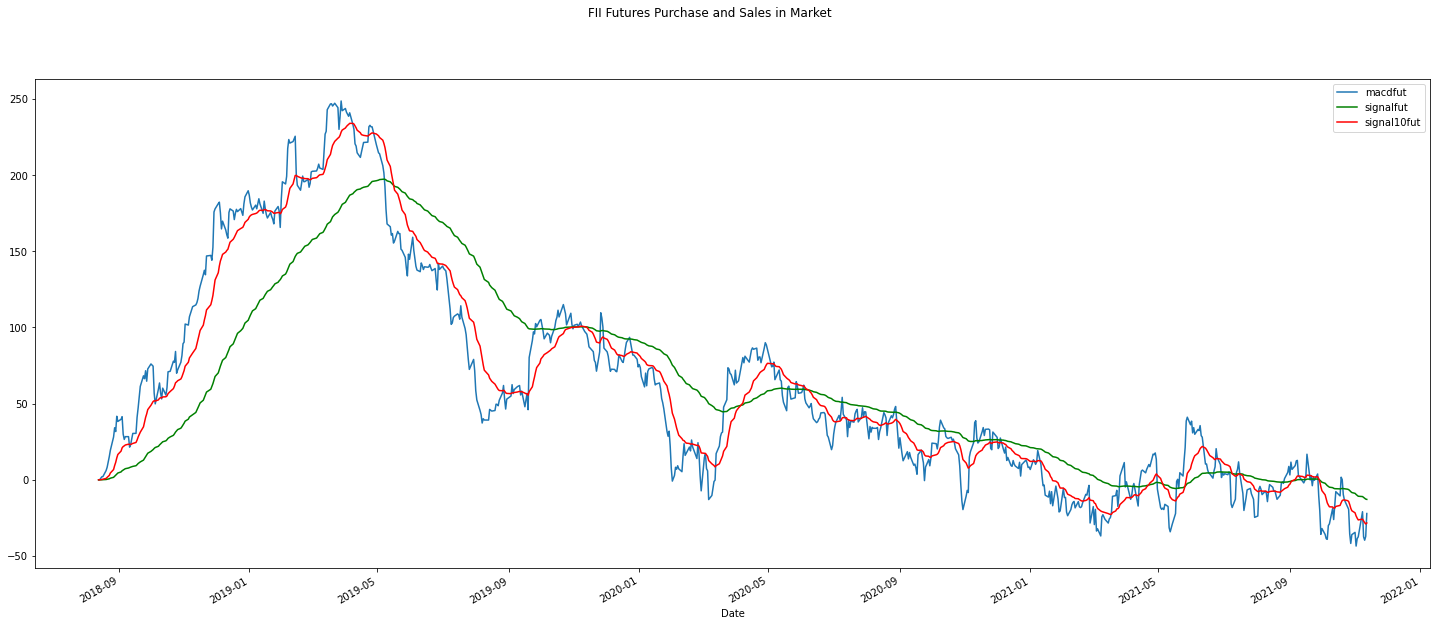

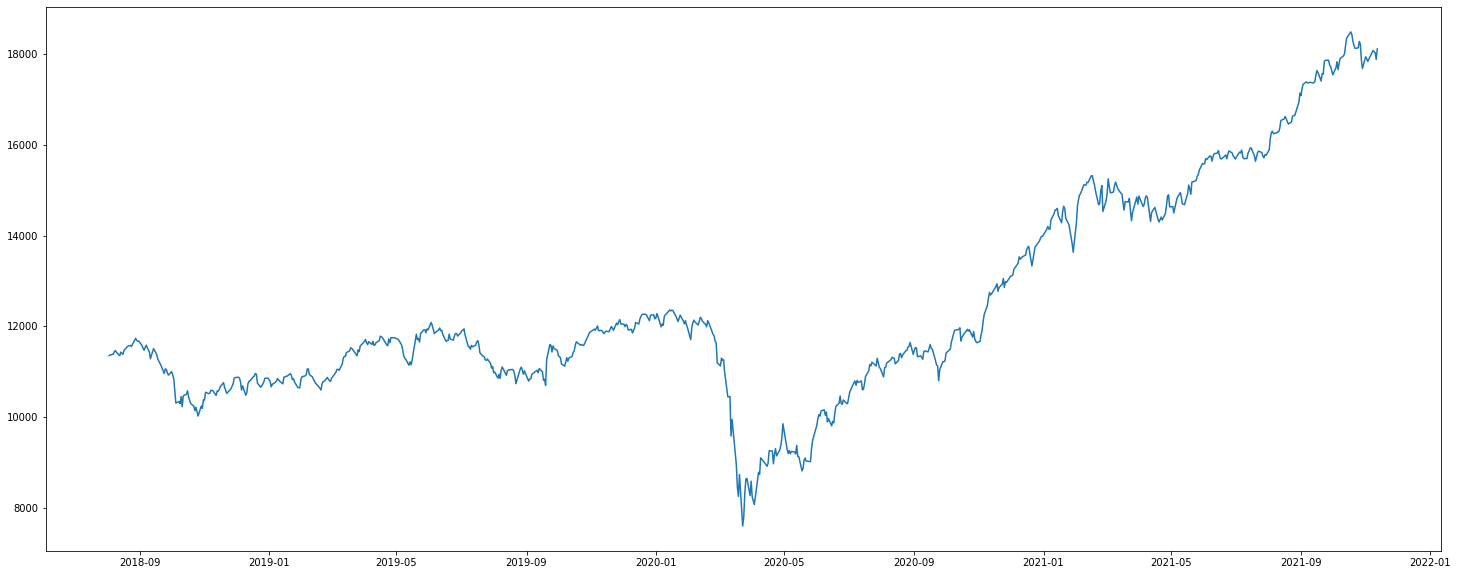

In [718]:
fii_fig['macdfut'].plot(figsize=(25,10))
fii_fig['signalfut'].plot(color='g')
fii_fig['signal10fut'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Futures Purchase and Sales in Market')
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()

# Plot FII minus DII

In [719]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=50, adjust=False).mean()-fii_fig['Cash'].ewm(span=100, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=25,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=10,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

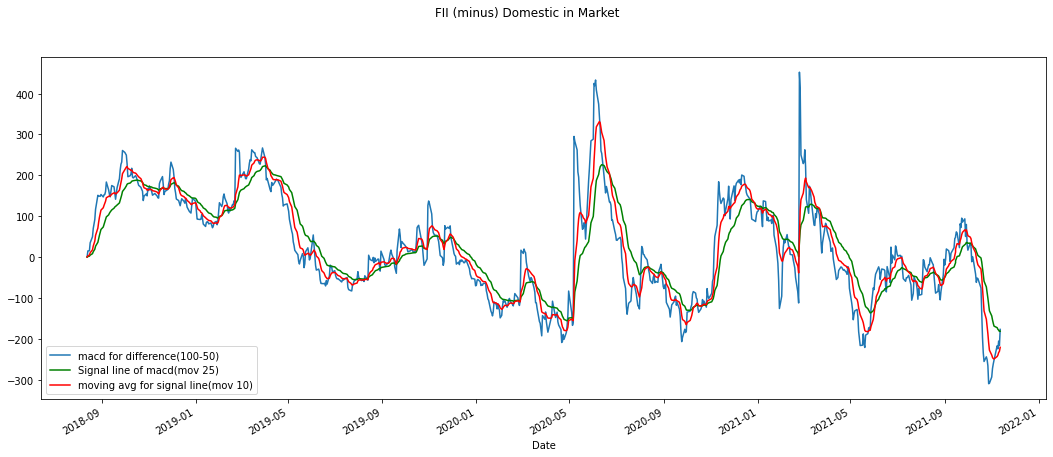

In [720]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(100-50)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 25)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 10)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [721]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=100, adjust=False).mean()-fii_fig['Cash'].ewm(span=250, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=45,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=20,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

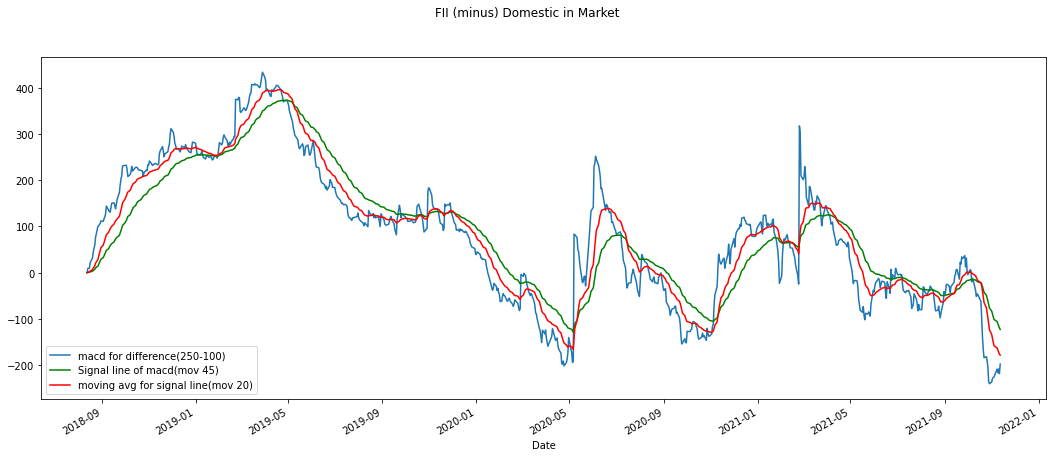

In [722]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(250-100)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 45)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 20)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [723]:
fii_fig['macd']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal']

In [724]:
fii_fig['macdx']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signalx']=fii_fig['macdx'].ewm(span=35,adjust=False).mean()
fii_fig['signal10x']=fii_fig['macdx'].ewm(span=10,adjust=False).mean()
fii_fig['histx']=fii_fig['macdx']-fii_fig['signalx']

# Plot FII , DII , Difference comparison

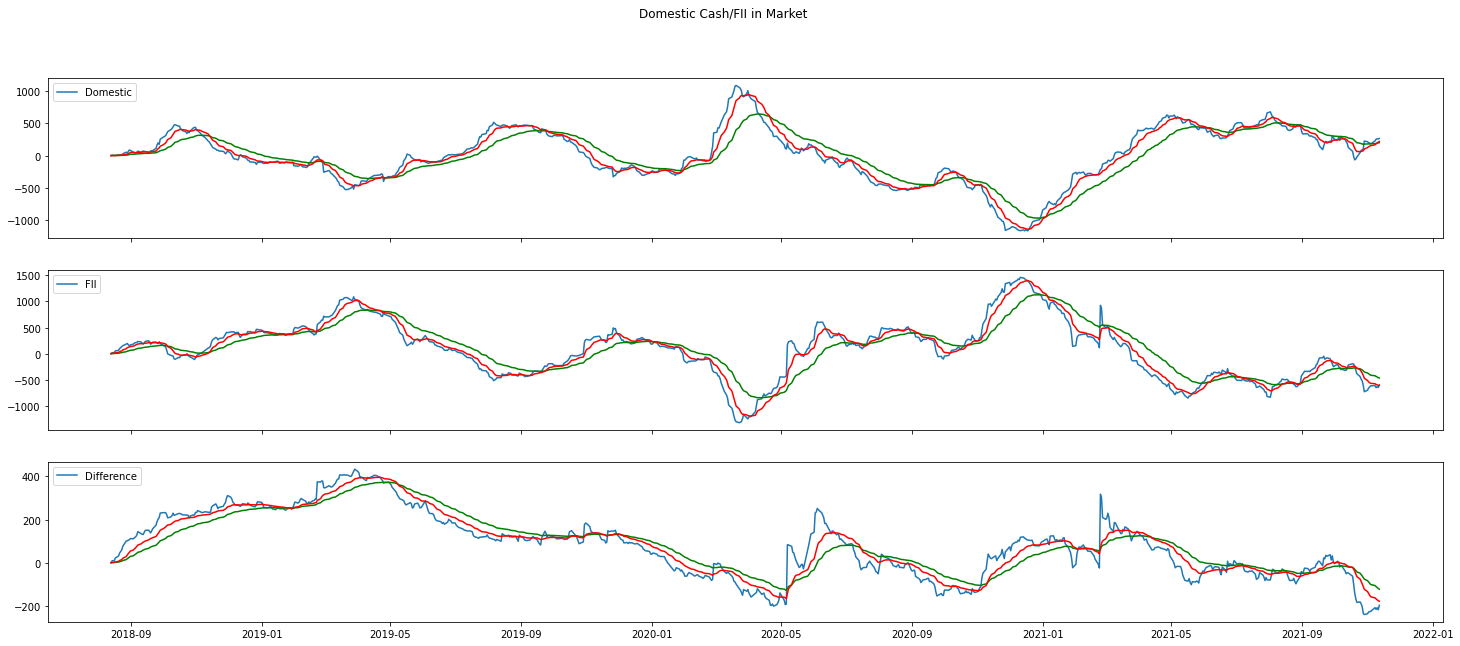

No handles with labels found to put in legend.


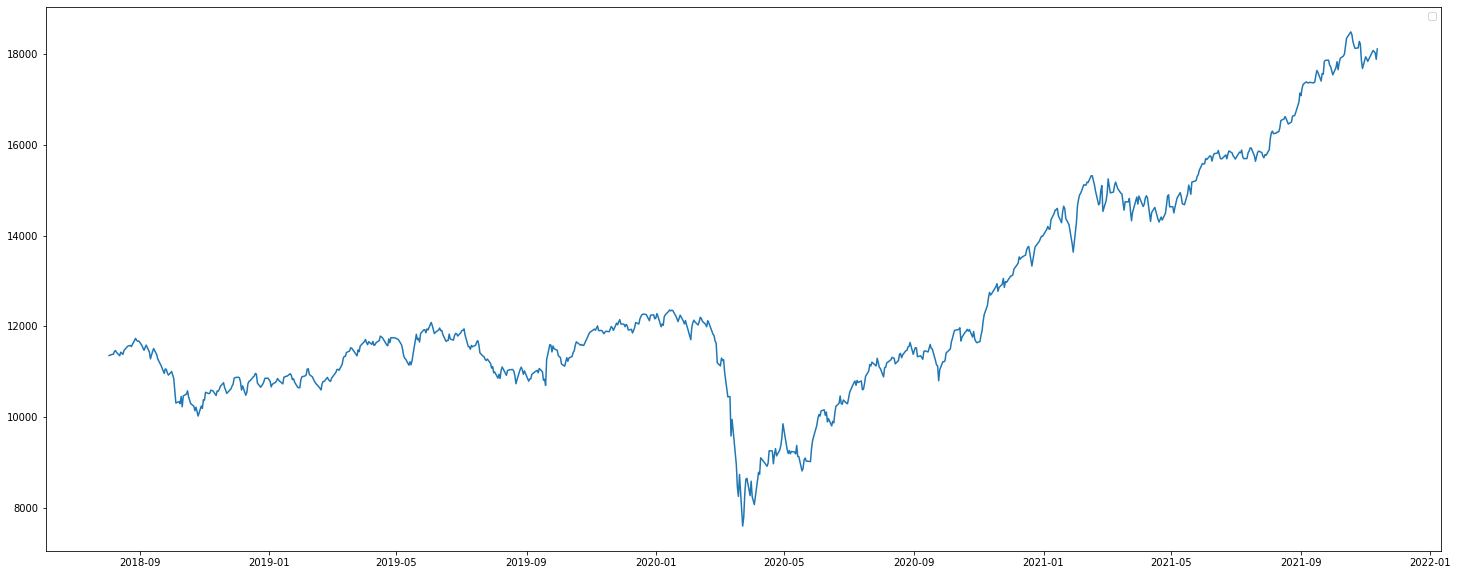

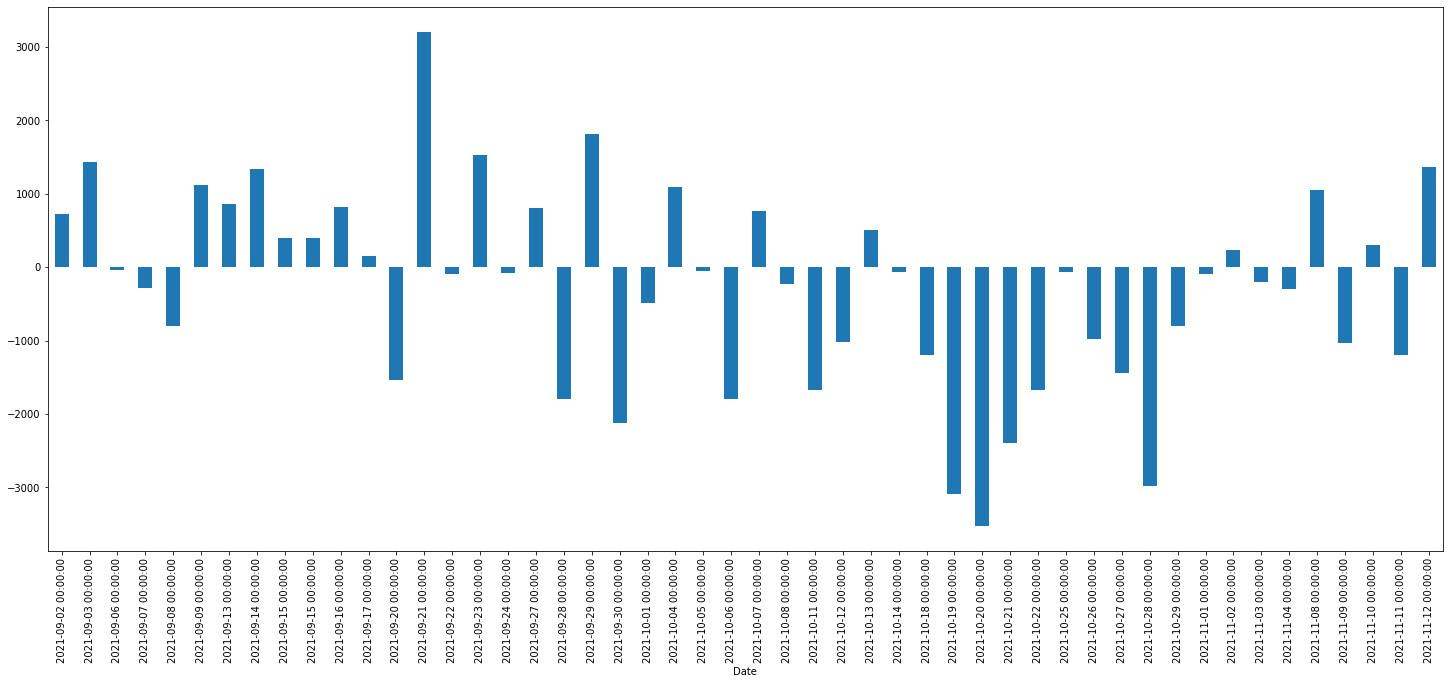

In [725]:
fig,ax=plt.subplots(3,1,figsize=(25,10),sharex=True)
ax[0].plot(fii_fig['macd'], label='Domestic')
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[2].plot(fii_fig['macdy'],label='Difference')
ax[2].plot(fii_fig['signaly'],color='g')
ax[2].plot(fii_fig['signal10y'],color='r')
#plt.plot(fii_fig.loc[:, :].index)
ax[1].plot(fii_fig['macdx'],label='FII')
ax[1].plot(fii_fig['signalx'],color='g')
ax[1].plot(fii_fig['signal10x'],color='r')

#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('Domestic Cash/FII in Market')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
#plt.xaxis.set_major_locator(mloc)
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
fii_fig['Cash'][-50:].plot.bar()
plt.show()

In [726]:
fii_fig.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Cash,macdfut,signalfut,signal10fut,histfut,macdy,signaly,signal10y,histy,macd,signal,signal10,hist,macdx,signalx,signal10x,histx
Date,,,,,,,,,,,,,,,,,,,,,,,
2021-11-11,-5.4,-3.6,193,14748,-1637,446,-1191,-37.154835,-12.644253,-28.977508,-24.510582,-218.255103,-119.398265,-176.129093,-98.856838,256.363976,195.447542,207.093103,60.916434,-649.185318,-459.270742,-607.812264,-189.914576
2021-11-12,52.0,-18.5,2103,15368,511,851,1362,-22.114981,-12.841560,-28.323934,-9.273420,-197.612000,-122.798862,-178.175084,-74.813138,265.155704,199.320218,217.649940,65.835486,-600.980935,-467.143531,-606.570204,-133.837404


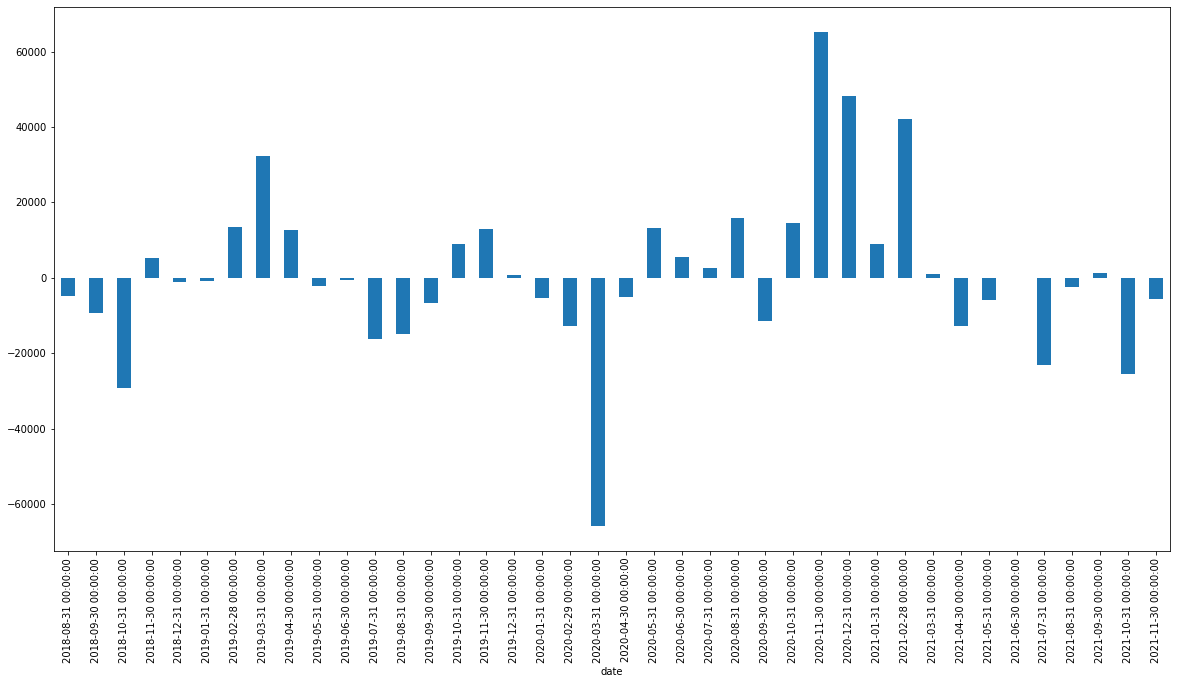

In [727]:
fii_fig=fii_fig.reset_index()
fii_fig['date']=pd.to_datetime(fii_fig['Date'])
fii_fig = fii_fig.set_index('date')
fii_fig.FIICash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

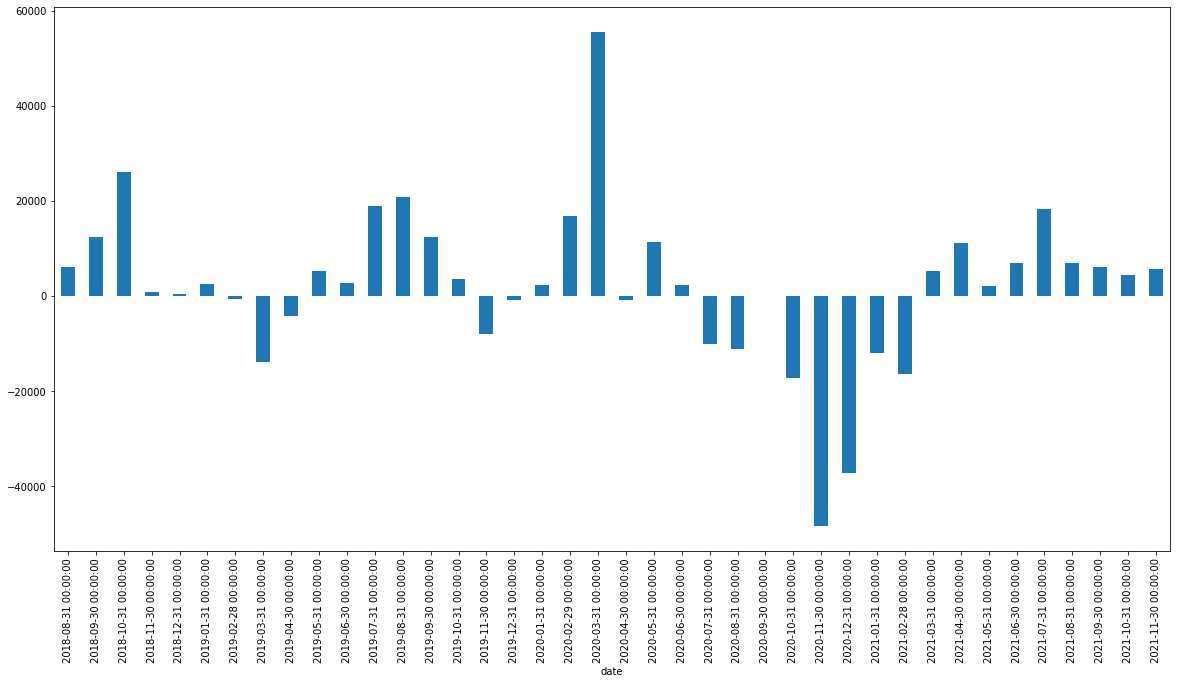

In [728]:
fii_fig.DIIcash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

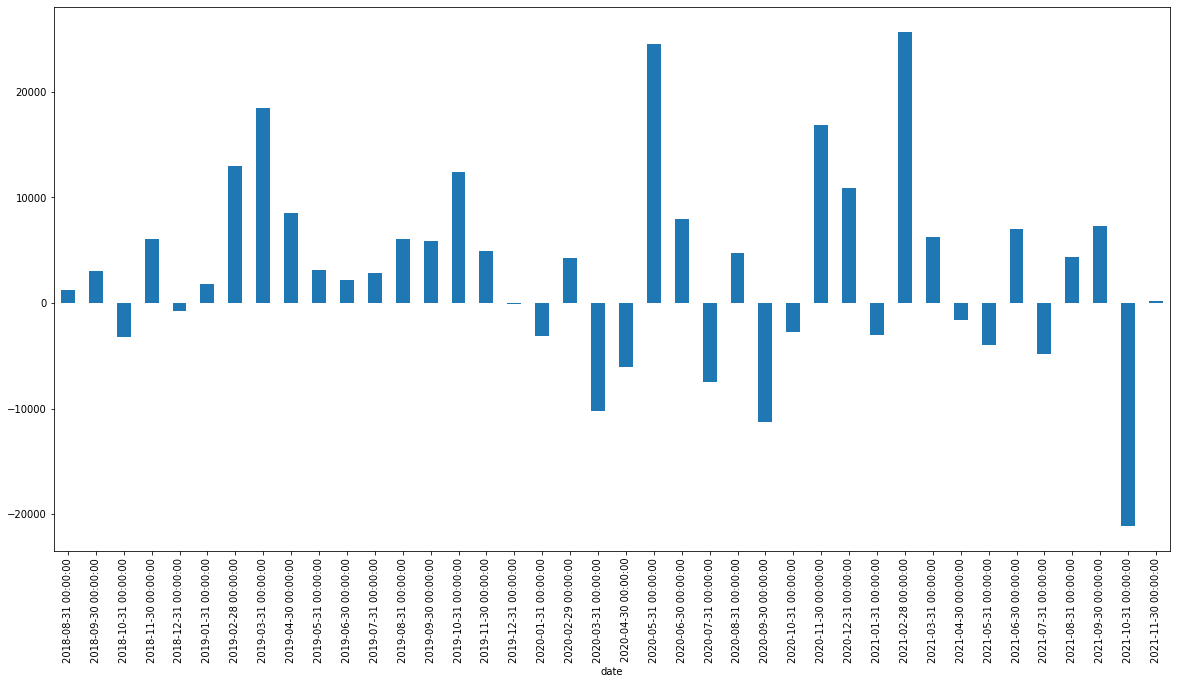

In [729]:
fii_fig.Cash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()


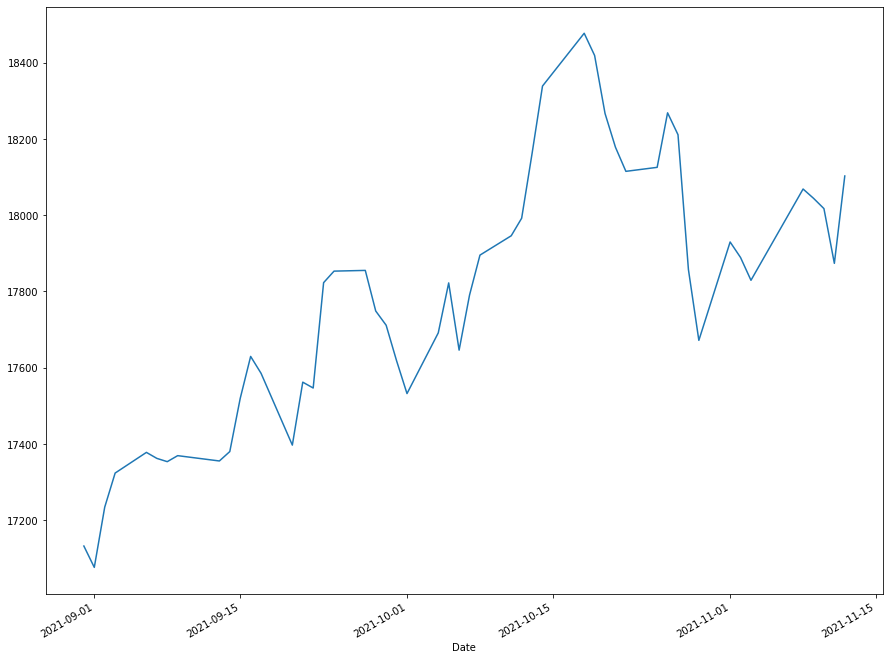

In [730]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [731]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [732]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 


In [733]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=100, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

In [734]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

# Plot Smart Money (FII)

In [735]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
nif.reset_index(inplace=True)
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['signal10'], mode='lines', name = 'signal10'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(title_text="Smart Money And Nifty")

fig.show()

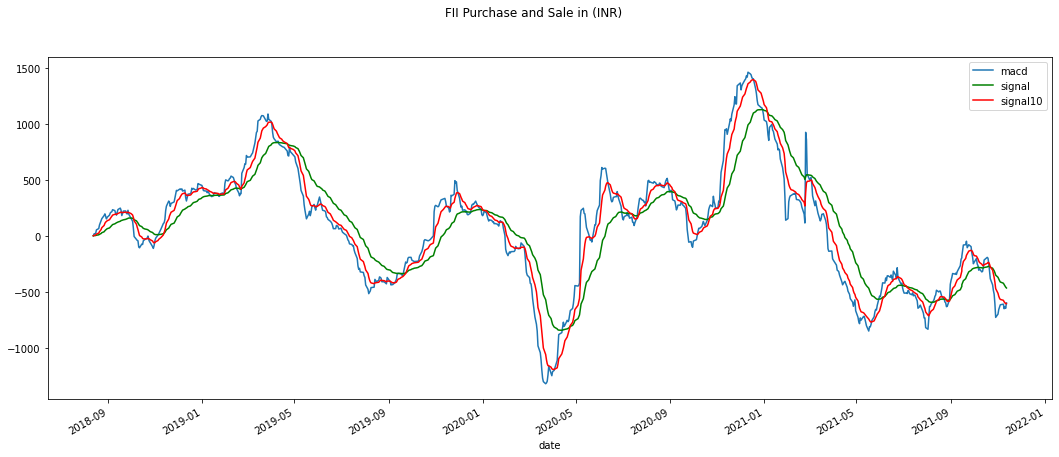

In [736]:
fii_fig['macd'].plot(figsize=(18,7))
fii_fig['signal'].plot(color='g')
fii_fig['signal10'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Purchase and Sale in (INR)')
plt.legend()
plt.show()


In [737]:
nifty['fsig']=np.where(fii_fig['macd']>fii_fig['signal'],1,0)

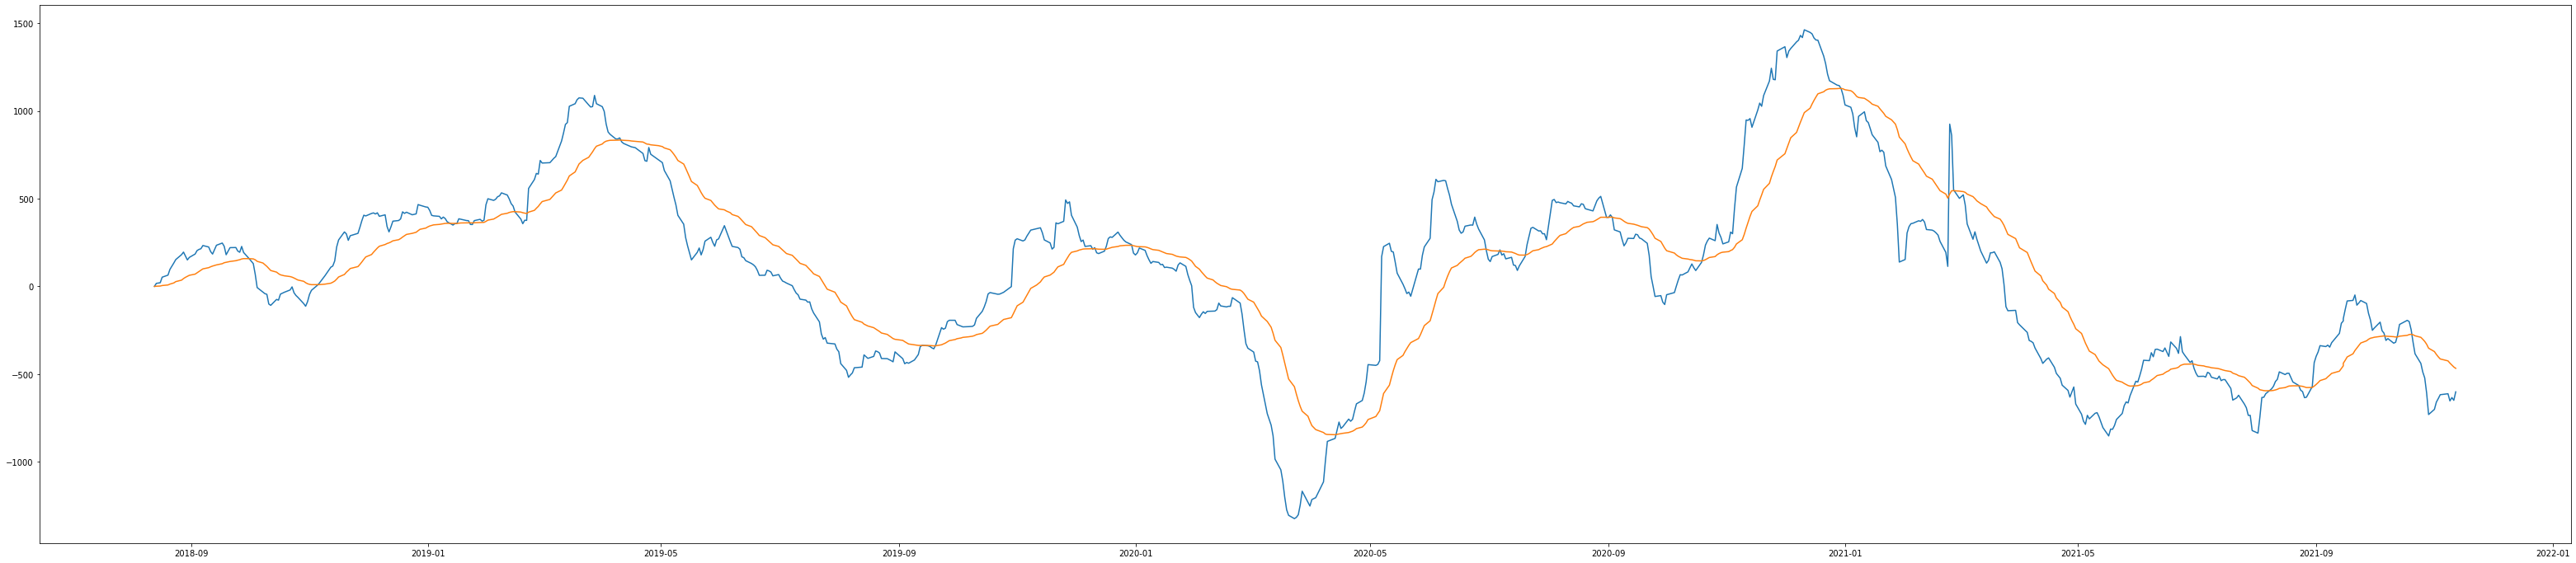

In [738]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()

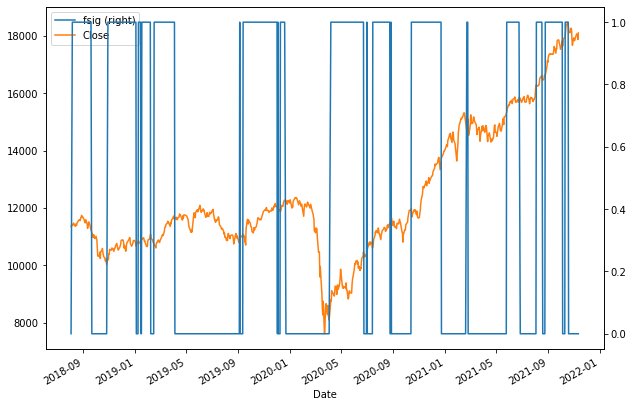

In [741]:
nifty[['fsig','Close']].plot(secondary_y='fsig',figsize=(10,7));